# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import optuna

# Datasets

In [2]:
arrhyData=pd.read_csv('Arrhythmia cleaned data.csv')
arrhyData.head()

,Age,Sex,Height,Weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,Q wave V6,R wave V6,S wave V6,R' wave V6,S' wave V6,P wave V6,T wave V6,QRSA V6,QRSTA V6,label
0,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,5
1,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,7
2,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,0
3,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,0
4,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,0


<AxesSubplot:xlabel='label', ylabel='count'>

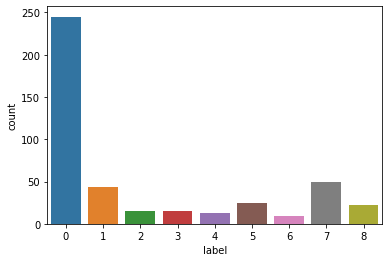

In [3]:
sns.countplot(x='label',data=arrhyData)

# Build the model

#divide the train and test dataset

#feature project

#Choose features 

#Superparameter optimization

In [4]:
arrhyData.shape

(438, 279)

In [5]:
arrhyData01=arrhyData.copy()

In [6]:
X1=arrhyData01.drop(labels=['label'],axis=1)

y1=arrhyData01['label'].values


In [7]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

### Artificial Neural Network

Load data

In [8]:
pca1 =PCA(n_components=None, copy=True, whiten=False)
pcamodel1 = pca1.fit(X1)

In [9]:
print("Explained Variance: %s") 
print(pcamodel1.components_)

pcamodel1.n_components_

newMat1=pcamodel1.fit_transform(X1) 
X_pca1 = DataFrame(newMat1)
X31_train, X31_test,y31_train,y31_test= train_test_split(X_pca1,y1,test_size=0.2,shuffle=True,stratify=y1,random_state=42)

Explained Variance: %s
[[ 6.73351726e-02 -1.90862962e-02  1.72037300e-03 ... -9.14346524e-02
  -8.66927095e-02 -1.30482728e-01]
 [ 5.88844957e-02  8.46249319e-03 -3.67779384e-02 ... -8.23138154e-02
   1.85551382e-01  6.68947820e-02]
 [-1.02524819e-02 -4.55955088e-02  2.09373517e-02 ... -6.23684539e-02
  -1.86015633e-02 -6.03188860e-02]
 ...
 [ 0.00000000e+00  1.45728434e-17  2.12146261e-16 ... -1.73472348e-17
  -3.37403716e-16  1.79977561e-17]
 [ 0.00000000e+00 -1.74153893e-31 -3.80182235e-31 ... -4.03674916e-31
  -8.24298016e-32  4.16963833e-31]
 [-0.00000000e+00 -1.35134848e-31 -9.38973165e-32 ... -3.29719206e-31
  -2.08867102e-31  4.00978614e-31]]


In [10]:
len(pcamodel1.components_)

278

In [11]:
X_train = torch.from_numpy(X31_train.values)
y_train = torch.from_numpy(y31_train ).type(torch.LongTensor)

X_test  = torch.from_numpy(X31_test.values )
y_test= torch.from_numpy(y31_test).type(torch.LongTensor)

batch_size = 128
train = torch.utils.data.TensorDataset(X_train, y_train )
test = torch.utils.data.TensorDataset(X_test , y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [12]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        return out


In [13]:
epochs =30
batch_size = X31_train.shape[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X_pca1.shape[1]
hidden_dim =49 #hidden layer1

output_dim = len(set(y1))

In [14]:
model = ANNModel(input_dim, hidden_dim, output_dim)


learning_rate = 0.0023
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [15]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) # 将double数据转换为float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #反向传播优化网络参数
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #累加每个step的损失
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann/epochs).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:2.2337 accuracy:0.0625 precision:0.0625 recall:0.0625 f1:0.0625
[sklearn_metrics] Epoch:0 loss:4.1224 accuracy:0.2930 precision:0.2930 recall:0.2930 f1:0.2930
[sklearn_metrics] Epoch:0 loss:5.7804 accuracy:0.3857 precision:0.3857 recall:0.3857 f1:0.3857
[sklearn_metrics] Epoch:1 loss:1.1161 accuracy:0.7500 precision:0.7500 recall:0.7500 f1:0.7500
[sklearn_metrics] Epoch:1 loss:2.0840 accuracy:0.7539 precision:0.7539 recall:0.7539 f1:0.7539
[sklearn_metrics] Epoch:1 loss:2.9838 accuracy:0.7657 precision:0.7657 recall:0.7657 f1:0.7657
[sklearn_metrics] Epoch:2 loss:0.6963 accuracy:0.7969 precision:0.7969 recall:0.7969 f1:0.7969
[sklearn_metrics] Epoch:2 loss:1.1809 accuracy:0.8477 precision:0.8477 recall:0.8477 f1:0.8477
[sklearn_metrics] Epoch:2 loss:1.8395 accuracy:0.8343 precision:0.8343 recall:0.8343 f1:0.8343
[sklearn_metrics] Epoch:3 loss:0.4060 accuracy:0.9141 precision:0.9141 recall:0.9141 f1:0.9141
[sklearn_metrics] Epoch:3 loss:0.8656 accuracy:0.8

[sklearn_metrics] Epoch:36 loss:0.0087 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:36 loss:0.0184 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:36 loss:0.0282 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:37 loss:0.0094 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:37 loss:0.0173 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:37 loss:0.0267 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:38 loss:0.0081 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:38 loss:0.0170 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:38 loss:0.0253 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:39 loss:0.0090 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:39 loss:0.0165 a

[sklearn_metrics] Epoch:73 loss:0.0047 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:73 loss:0.0074 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:74 loss:0.0020 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:74 loss:0.0047 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:74 loss:0.0071 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:75 loss:0.0021 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:75 loss:0.0045 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:75 loss:0.0069 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:76 loss:0.0022 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:76 loss:0.0044 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:76 loss:0.0067 a

[sklearn_metrics] Epoch:110 loss:0.0029 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:111 loss:0.0011 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:111 loss:0.0020 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:111 loss:0.0028 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:112 loss:0.0010 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:112 loss:0.0020 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:112 loss:0.0027 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:113 loss:0.0009 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:113 loss:0.0018 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:113 loss:0.0027 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:114 lo

[sklearn_metrics] Epoch:148 loss:0.0004 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:148 loss:0.0008 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:148 loss:0.0013 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:149 loss:0.0004 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:149 loss:0.0008 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:149 loss:0.0013 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
0.0153
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        49
           1       0.33      0.56      0.42         9
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         3
           5       0.67      0.40      0.50         5
           6       1.00      0.5

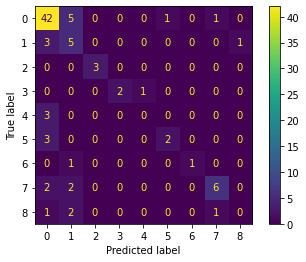

In [16]:
ConfusionMatrixDisplay.from_predictions(test_trues, test_preds)

plt.show()

In [17]:
print(classification_report(test_trues, test_preds,zero_division=1))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        49
           1       0.33      0.56      0.42         9
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         3
           5       0.67      0.40      0.50         5
           6       1.00      0.50      0.67         2
           7       0.75      0.60      0.67        10
           8       0.00      0.00      0.00         4

    accuracy                           0.69        88
   macro avg       0.61      0.51      0.54        88
weighted avg       0.68      0.69      0.68        88



In [18]:
print(accuracy_score(test_trues, test_preds))

0.6931818181818182


<AxesSubplot:>

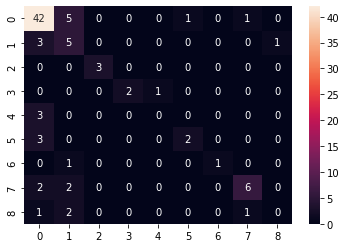

In [19]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_trues, test_preds))

sns.heatmap(confusion_matrix_df, annot=True)

In [20]:
ann_accuracy='%.4f'% accuracy_score(test_trues, test_preds)


ann_f1='%.4f'% f1_score(test_trues, test_preds, average='micro')


ann_roc_auc='%.4f'% roc_auc_score(test_trues,probs,multi_class='ovr',labels=np.unique(test_trues))

In [21]:
ann_loss='%.4f'% testloss

In [22]:
ann_accuracy

'0.6932'

In [23]:
ann_f1

'0.6932'

In [24]:
ann_roc_auc

'0.7725'

In [25]:
ann_loss

'1.6952'

Define the Optuna  model

In [26]:

# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 278
# looping to determine the number of layers and nodes in each layer     
    for i in range(n_layers):
#         the number of nodes in each layer.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
#         p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#         layers.append(nn.Dropout(p))
        
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 9))
#     layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in test_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model, trial)

    return accuracy
  
EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)



[I 2022-09-03 23:35:39,132] A new study created in memory with name: no-name-5e2f69ee-b4df-424e-bcb9-8a2d5e9dd02a
C:\Users\COOLER~1\AppData\Local\Temp/ipykernel_14668/209683948.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2022-09-03 23:35:39,424] Trial 0 finished with value: 0.056818181818181816 and parameters: {'learning_rate': 7.271681790555494e-05, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 47}. Best is trial 0 with value: 0.056818181818181816.
[I 2022-09-03 23:35:39,665] Trial 1 finished with value: 0.6931818181818182 and parameters: {'learning_rate': 0.00864760517240224, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 73}. Best is trial 1 with value: 0.6931818181818182.
[I 2022-09-03 23:35:39,917] Tria

In [27]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.0023352063024496697
optimizer: RMSprop
n_layers: 1
n_units_l0: 101


In [28]:
# 0.7386363636363636.
# learning_rate: 0.008664150596328149
# optimizer: RMSprop
# n_layers: 1
# n_units_l0: 125
# 0.7045

In [29]:
# 0.75
# learning_rate: 0.004769203415826575
# optimizer: RMSprop
# n_layers: 1
# n_units_l0: 54
# 0.7159

In [30]:
# 0.7386363636363636.
# learning_rate: 0.0008230640739791282
# optimizer: Adam
# n_layers: 1
# n_units_l0: 98
# 0.7159